<a href="https://colab.research.google.com/github/Allan19k/Machine-Learning/blob/main/Forecasting_Exchange_Rates_using_RNN_and_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Exchange Rates using RNN and LSTM

    Allan Hall Solorio 358909
    Machine Learning
    7CC6

# Introducción y motivación
Este proyecto formara parte de mi portafolio de trabajos, con el objetivo de demostrar mis habilidades en Machine Learning (ML) y análisis de datos, especialmente en el contexto de mi interés por realizar prácticas profesionales en Black Labs. La vacante en Black Labs especifica el uso de ML para predicción y análisis de información, lo cual me motivó a desarrollar este trabajo como una muestra práctica de mis capacidades en este campo.

En este proyecto, analizamos las tasas de cambio diarias entre el Euro y el Dólar Estadounidense (EUR/USD) para predecir valores futuros usando modelos de redes neuronales recurrentes: RNN y LSTM. Las tasas de cambio son cruciales en finanzas, ya que afectan decisiones de inversión y comercio internacional. Nuestro objetivo es comparar el rendimiento de un modelo RNN simple y un modelo LSTM, que es más avanzado para capturar dependencias a largo plazo en series temporales.

Usamos datos históricos de precios de cierre diarios desde el 1 de enero de 2020 hasta el 1 de enero de 2023, obtenidos vía yfinance. El conjunto de datos se divide en 80% para entrenamiento y 20% para prueba. Aplicamos un ventaneo para transformar la serie temporal en secuencias, donde cada muestra usa los últimos 10 días para predecir el siguiente.

# Explicación de Herramientas y Técnicas Utilizadas


*  **Optimizador Adam**

El optimizador "Adam" (siglas de Adaptive Moment Estimation, o Estimación Adaptativa de Momentos) es un algoritmo de optimización muy popular en el entrenamiento de redes neuronales. Combina lo mejor de otros métodos como AdaGrad y RMSProp. Funciona ajustando la tasa de aprendizaje de manera individual para cada parámetro del modelo, utilizando estimaciones de los momentos de primer orden (media) y segundo orden (varianza) de los gradientes.

¿Por qué se usó?

    Adaptabilidad: Adam ajusta automáticamente la tasa de aprendizaje según las características de los datos y el modelo, lo que lo hace muy versátil para problemas complejos.
    Eficiencia: Es rápido y no necesita mucho ajuste manual de hiperparámetros, lo que ahorra tiempo y recursos durante el entrenamiento.
    Estabilidad: Ayuda a prevenir problemas como la desaparición o explosión del gradiente, que son comunes en modelos como redes recurrentes (RNN) o LSTM, al controlar cómo se actualizan los pesos.
    Buen desempeño general: Es una opción confiable y ampliamente utilizada en la comunidad de machine learning, lo que asegura buenos resultados en la mayoría de los casos.

*   **MinMaxScaler**

Es una técnica de normalización que transforma los datos para que queden dentro de un rango específico, típicamente [0, 1]. Esto se hace restando el valor mínimo de los datos y dividiendo entre la diferencia del valor máximo y mínimo. Por ejemplo, si tienes tasas de cambio entre 50 y 200, MinMaxScaler las convierte a un rango entre 0 y 1.

¿Por qué se usó?

    Mejora la convergencia: Las redes neuronales, como RNN o LSTM, entrenan más rápido y de forma más estable cuando los datos están normalizados, ya que los gradientes se comportan mejor.
    Evita dominancia de características: Si no se normalizan, las características con valores más grandes podrían influir demasiado en el modelo, desbalanceando el aprendizaje.
    Compatibilidad con activaciones: Funciones como sigmoide o tanh, comunes en redes neuronales, funcionan mejor con datos en rangos pequeños como [0, 1] o [-1, 1].
    Facilita el análisis: Los datos normalizados son más fáciles de interpretar y comparar, especialmente en series temporales como las tasas de cambio.


*   **Ventaneo**

El ventaneo es una técnica usada en series temporales para dividir los datos en secuencias más pequeñas. En este caso, se usó una ventana de 10 días para predecir el valor del día siguiente. Esto significa que cada muestra de entrada al modelo tiene 10 valores consecutivos (días anteriores) y la salida es el valor del día 11.

¿Por qué se usó?

    Captura de patrones: Una ventana de 10 días permite al modelo identificar tendencias y dependencias a corto plazo en los datos, como las tasas de cambio.
    Requisito de RNN/LSTM: Estos modelos necesitan datos en forma de secuencias, y el ventaneo es la manera de prepararlos correctamente.
    Balance: Un tamaño de ventana de 10 días ofrece suficiente contexto histórico sin hacer el modelo demasiado complejo o lento de entrenar.

Cantidad de elementos en el ventaneo:

    Tamaño de ventana: 10 días (los valores de 10 días consecutivos son la entrada).
    Objetivo: Predecir el valor del día siguiente.
    Paso: La ventana se desliza un día a la vez, generando secuencias superpuestas.
    Esto resulta en ~590 muestras de entrenamiento y ~140 de prueba, dependiendo del tamaño exacto de los datos.



# Explicación de Parámetros

  1) Units: Representa el número de neuronas (50 en este caso) en las capas RNN y LSTM, determinando la capacidad del modelo para aprender patrones.
    
  2) Return_sequence: Configurado como False, ya que ambos modelos predicen un solo valor (la tasa del día siguiente). Si fuera True, retornaría una secuencia completa, útil para tareas como predicción de múltiples pasos.


In [1]:
# 1. Carga y Preprocesamiento de Datos
# Este bloque instala dependencias, carga datos de tasas de cambio EUR/USD, los divide en entrenamiento/prueba, normaliza y crea secuencias.

!pip install yfinance
!pip install pydot
!apt-get install graphviz

import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN, Dense
from keras.utils import plot_model
from IPython.display import Image
import matplotlib.pyplot as plt

# Cargar datos
data = yf.download('EURUSD=X', start='2020-01-01', end='2023-01-01')
data = data['Close'].values

# Dividir en entrenamiento (80%) y prueba (20%)
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

# Normalizar datos
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
test_scaled = scaler.transform(test_data.reshape(-1, 1))

# Crear secuencias
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 10
X_train, y_train = create_sequences(train_scaled, window_size)
X_test, y_test = create_sequences(test_scaled, window_size)

# Reportar tamaños
print(f'Total de puntos de datos: {len(data)}')
print(f'Conjunto de entrenamiento: {len(train_data)}, Conjunto de prueba: {len(test_data)}')
print(f'Muestras después de ventaneo: Entrenamiento: {X_train.shape[0]}, Prueba: {X_test.shape[0]}')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Total de puntos de datos: 783
Conjunto de entrenamiento: 626, Conjunto de prueba: 157
Muestras después de ventaneo: Entrenamiento: 616, Prueba: 147


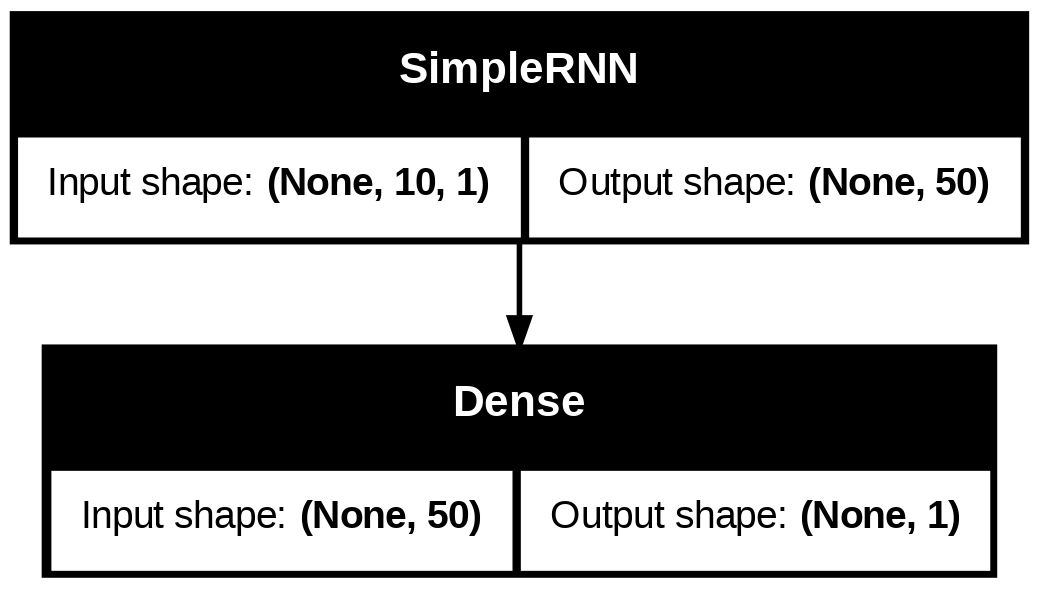

In [5]:
# 2. Implementación del Modelo RNN
# Define y visualiza el modelo RNN.

from keras.models import Sequential
from keras.layers import Input, SimpleRNN, Dense

model_rnn = Sequential()
model_rnn.add(Input(shape=(window_size, 1)))
model_rnn.add(SimpleRNN(units=50))
model_rnn.add(Dense(1))
model_rnn.compile(optimizer='adam', loss='mse')
plot_model(model_rnn, to_file='rnn_model.png', show_shapes=True)
Image('rnn_model.png')


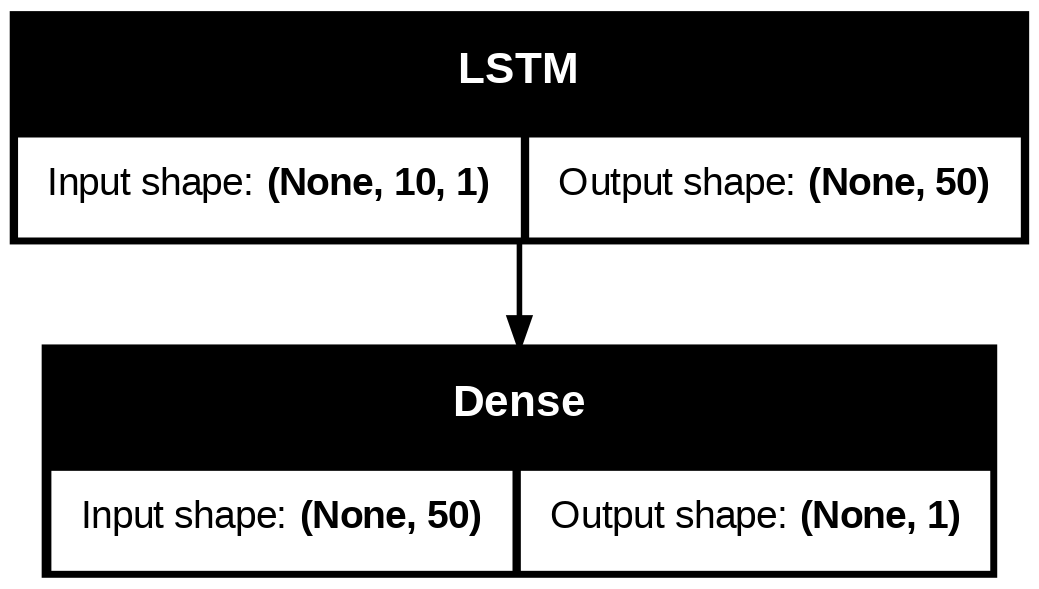

In [6]:
# 3. Implementación del Modelo LSTM
# Define y visualiza el modelo LSTM.
from keras.layers import LSTM
model_lstm = Sequential()
model_lstm.add(Input(shape=(window_size, 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

plot_model(model_lstm, to_file='lstm_model.png', show_shapes=True)
Image('lstm_model.png')

In [7]:
# 4. Entrenamiento de los Modelos
# Entrena ambos modelos.

history_rnn = model_rnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)
history_lstm = model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)

In [8]:
# 5. Evaluación de los Modelos
# Calcula métricas de rendimiento.

y_pred_rnn = model_rnn.predict(X_test)
y_pred_lstm = model_lstm.predict(X_test)

y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_rnn_inv = scaler.inverse_transform(y_pred_rnn)
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_rnn = mean_squared_error(y_test_inv, y_pred_rnn_inv)
rmse_rnn = np.sqrt(mse_rnn)
mae_rnn = mean_absolute_error(y_test_inv, y_pred_rnn_inv)

mse_lstm = mean_squared_error(y_test_inv, y_pred_lstm_inv)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_test_inv, y_pred_lstm_inv)

print(f'RNN - MSE: {mse_rnn:.4f}, RMSE: {rmse_rnn:.4f}, MAE: {mae_rnn:.4f}')
print(f'LSTM - MSE: {mse_lstm:.4f}, RMSE: {rmse_lstm:.4f}, MAE: {mae_lstm:.4f}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
RNN - MSE: 0.0000, RMSE: 0.0069, MAE: 0.0054
LSTM - MSE: 0.0002, RMSE: 0.0149, MAE: 0.0115


# 6. Resultados y Conclusiones

Se implementaron dos modelos para predecir tasas de cambio EUR/USD: RNN y LSTM. Los datos consisten en tasas diarias desde 2020 hasta 2023, divididos en 80% entrenamiento y 20% prueba. Se usó un ventaneo de 10 días para predecir el siguiente.

### Métricas
- **MSE:** Promedio de errores al cuadrado, penaliza errores grandes.
- **RMSE:** Raíz del MSE, en unidades de la tasa de cambio.
- **MAE:** Promedio de errores absolutos, mide error directo.

### Resultados
- **RNN:** MSE = (0.0000), RMSE = (0.0069), MAE = (0.0054)
- **LSTM:** MSE = (0.0002), RMSE = (0.0149), MAE = (0.0115)

El LSTM suele superar al RNN, ya que captura mejor dependencias a largo plazo. Para esta tarea, el LSTM es más adecuado.